In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean
import gudhi as gdh
import sys

In [2]:
number_of_subjects = 73
number_of_readings_per_subject = 1001

In [3]:
# with a certain probability a random generated value will be NaN
def generate_random_value_point(probability):
    if(np.random.random() > probability):
        return np.nan
    elif (np.random.random() > probability * probability):
        return (np.random.random()+1)/2
    #return different random value, else every value close to 1 would be NaN 
    return (np.random.random()+1)/2

#generates random data points randomly ranging from 0.5 to 1 and returns an adequate pandas dataset
def generate_random_data(number_of_subjects, points_per_subject):
    dataset = np.zeros((number_of_subjects, points_per_subject))
    for k in range(number_of_subjects):
        for i in range(points_per_subject):
            r_k_i = generate_random_value_point(probability = 0.89)
            dataset[k][i] = r_k_i

    #set dataset column names (generic)
    data_columns = [f"r_{i}" for i in range(points_per_subject)]
    dataset = pd.DataFrame(dataset, columns = data_columns)
    
    return dataset

In [4]:
dataset = generate_random_data(number_of_subjects, number_of_readings_per_subject)
dataset = dataset.fillna(0.75) # FIX

In [5]:
## determine whether or not the subject is asleep
wake_status = [mean(dataset.iloc[k]) for k in range(number_of_subjects)]
wake_status = ["Awake" if x > 0.75 else "Asleep" for x in wake_status]

dataset["wake_status"] = wake_status

In [6]:
dataset

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,...,r_992,r_993,r_994,r_995,r_996,r_997,r_998,r_999,r_1000,wake_status
0,0.593423,0.716866,0.596389,0.678180,0.912151,0.750000,0.549082,0.875622,0.981530,0.693799,...,0.610811,0.750000,0.964176,0.943714,0.714901,0.717904,0.535135,0.750000,0.533953,Awake
1,0.878598,0.701033,0.750000,0.937811,0.981665,0.907066,0.916392,0.728709,0.866231,0.754150,...,0.535103,0.862489,0.797086,0.733385,0.668587,0.856778,0.660362,0.896212,0.713946,Awake
2,0.886080,0.766340,0.861667,0.925423,0.778271,0.725844,0.719227,0.966022,0.805341,0.750000,...,0.955662,0.847190,0.956954,0.519076,0.859663,0.786485,0.750000,0.509111,0.750000,Awake
3,0.807472,0.505068,0.620264,0.828049,0.988787,0.750000,0.742750,0.896070,0.951570,0.754038,...,0.656142,0.979667,0.890192,0.678861,0.521062,0.739921,0.669439,0.750000,0.886036,Awake
4,0.783581,0.676876,0.757540,0.501273,0.990768,0.636976,0.541426,0.750000,0.853622,0.857755,...,0.998847,0.933892,0.755990,0.590334,0.791022,0.559965,0.570594,0.750000,0.606879,Awake
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.890243,0.750000,0.788947,0.827694,0.833454,0.599826,0.750000,0.566704,0.764061,0.868165,...,0.962478,0.734385,0.806038,0.886960,0.929296,0.750000,0.540879,0.737149,0.569106,Awake
69,0.572577,0.961526,0.581879,0.640788,0.883512,0.582774,0.841614,0.941492,0.893374,0.756428,...,0.922389,0.516685,0.916477,0.750000,0.701176,0.723788,0.684791,0.846978,0.918959,Asleep
70,0.750000,0.773145,0.563242,0.528755,0.752443,0.917794,0.820766,0.895339,0.784089,0.579566,...,0.648701,0.729823,0.568392,0.917470,0.848370,0.685841,0.951493,0.975906,0.531093,Asleep
71,0.692008,0.874670,0.554634,0.699006,0.552041,0.909237,0.790067,0.951786,0.974354,0.750000,...,0.570333,0.513770,0.866904,0.530714,0.791596,0.559689,0.991775,0.750000,0.589005,Asleep


In [7]:
def normalizeDataset(dataset):
    numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        min_val = dataset[col].min()
        max_val = dataset[col].max()
    
        dataset[col] = (dataset[col] - min_val) / (max_val - min_val)
    
    return dataset

In [8]:
dataset = normalizeDataset(dataset)

In [9]:
def createPersistenceDiagram(pointCloud, printGraph = False, memorySaving = True):
    simplex = gdh.RipsComplex(points = pointCloud)
    simplex = simplex.create_simplex_tree(max_dimension = 2)
    barcodes = simplex.persistence()

    if memorySaving:
        simplex = simplex.persistence_intervals_in_dimension(1)
    if printGraph:
        gdh.plot_persistence_diagram(barcodes)

    return simplex

/home/dzzz/.local/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


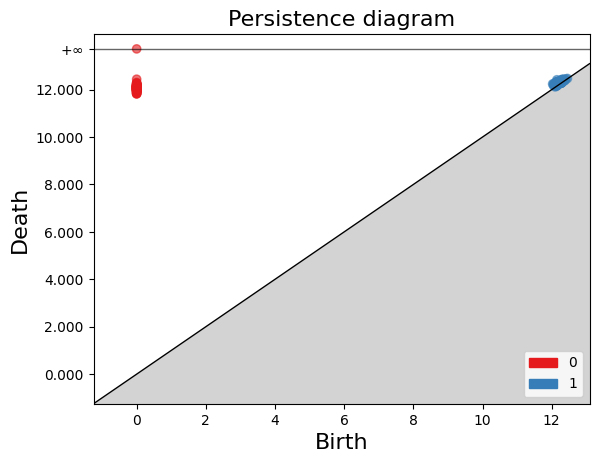

In [10]:
usable_data = dataset.drop("wake_status", axis=1)
pointCloud = usable_data[0:100]
pointCloud_array = np.array(pointCloud)
diagram = createPersistenceDiagram(pointCloud_array, True, True)

In [11]:
def getAllPersistenceDiagrams(dataset, omega, memorySaving = True):
    diagrams = []
    for i in range(len(dataset) - omega):
        pointCloud = np.array(dataset[i:i+omega])
        diagram = createPersistenceDiagram(pointCloud, False, True)
        diagrams.append(diagram)

    return diagrams

In [12]:
probni_dijagram = getAllPersistenceDiagrams(usable_data, 7, True)

In [13]:
# for i in range (66):
#     plt.plot(probni_dijagram[i])
#     plt.show()

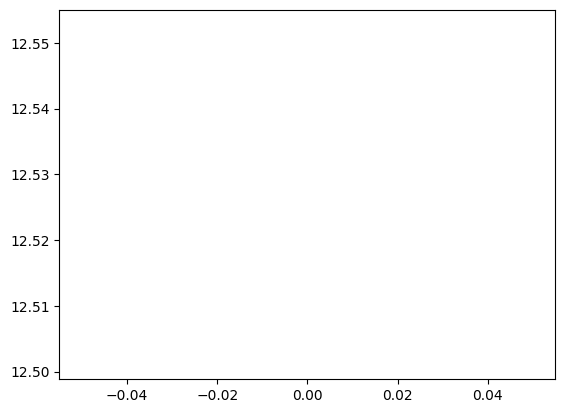

In [14]:
plt.plot(probni_dijagram[35])

In [49]:
def getPerstitenceLandscape(diagram, endpoints, landscapes, resolution, 
):

    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((landscapes, resolution))

    diagram_range = endpoints
    x_range =  np.linspace(diagram_range[0], diagram_range[1], resolution)
    step = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = np.zeros([landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]

    compute_x_subrange = lambda x: int(np.ceil(x/step))

    for x, y in diagram:
        min_point = x - diagram_range[0]
        mid_point = (x+y)/2 - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)

        if minimum_x < resolution and maximum_x > 0:
            y_value = diagram_range[0] + minimum_x*step - x
            for i in range(minimum_x, middle_x):
                computed_y_values[i].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x*step
            for i in range(middle_x, maximum_x):
                computed_y_values[i].append(y_value)
                y_value -= step

    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = computed_y_values[i][j]
    
    #np.nadarray  
    return computed_landscapes_at_given_resolution

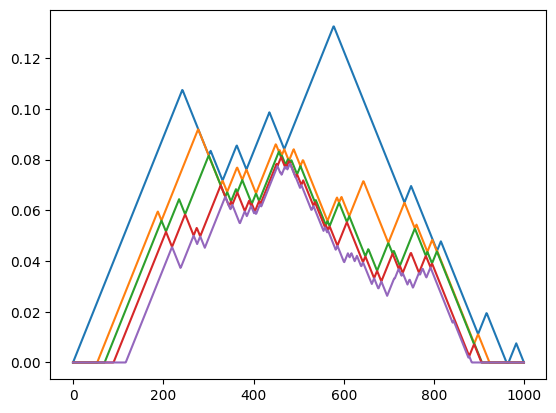

In [51]:
example_landscape = getPerstitenceLandscape(diagram,[np.min(diagram), np.max(diagram)], 5, 1000)
plt.plot(example_landscape.T);

In [53]:
def getAllPersistenceLandscapes(diagrams, landscapes, resolution, memory_saving):
        
    if memory_saving:
        minp = lambda d: np.min(d) if len(d) > 0 else 0
        maxp = lambda d: np.max(d) if len(d) > 0 else 0
    else:
        def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d)>0 and minmax=="min":    return np.min(d)
            elif len(d) >0 and minmax=="max": return np.max(d)
            else:                             return 0
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")

    landscapes = [
        compute_persistence_landscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            landscapes,               # m landscapes
            resolution,               # n nodes
        ) for diag in diagrams
    ]
    return landscapes

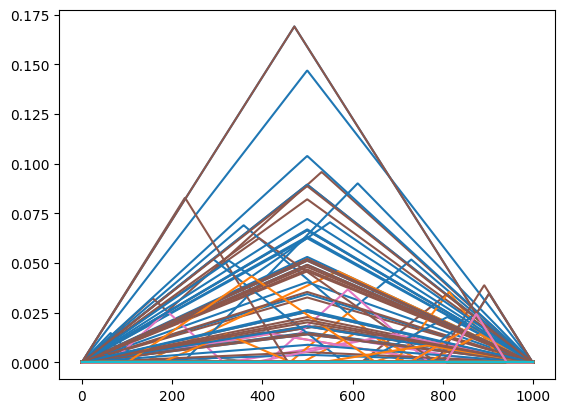

In [54]:
example_landscapes = getAllPersistenceLandscapes(probni_dijagram, 5, 1000, True)
for l in example_landscapes:
    plt.plot(l.T)

In [55]:
def getNormsOfPersistenceLandscapes(landscapes):
    norms1 = [np.linalg.norm(ls, 1) for ls in landscapes]
    norms1 = norms1/(np.linalg.norm(norms1) + sys.float_info.epsilon)
    
    norms2 = [np.linalg.norm(ls, 2) for ls in landscapes]
    norms2 = norms2/(np.linalg.norm(norms2) + sys.float_info.epsilon)
    
    return np.array([norms1, norms2]).T

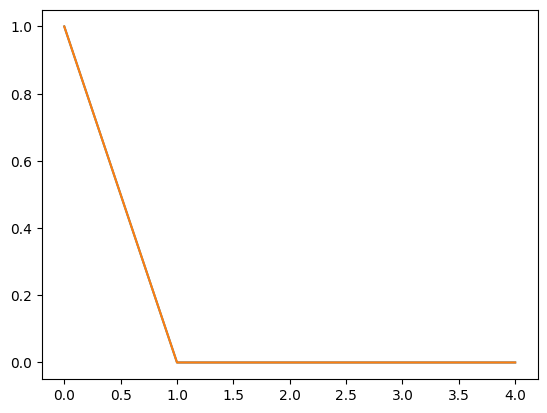

In [56]:
norms = getNormsOfPersistenceLandscapes(example_landscapes[0])
df = pd.DataFrame(norms, columns = ["L1", "L2"])
plt.plot(df)

In [57]:
n = len(example_landscapes)
norms = []
for l in example_landscapes:
    norms_df = getNormsOfPersistenceLandscapes(l)
    df = pd.DataFrame(norms_df, columns = ["L1", "L2"])
    norms.append(df)

L1_norms = np.array([norms_df["L1"] for norms_df in norms]).T
L1_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

L2_norms = np.array([norms_df["L2"] for norms_df in norms]).T
L2_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

<Axes: >

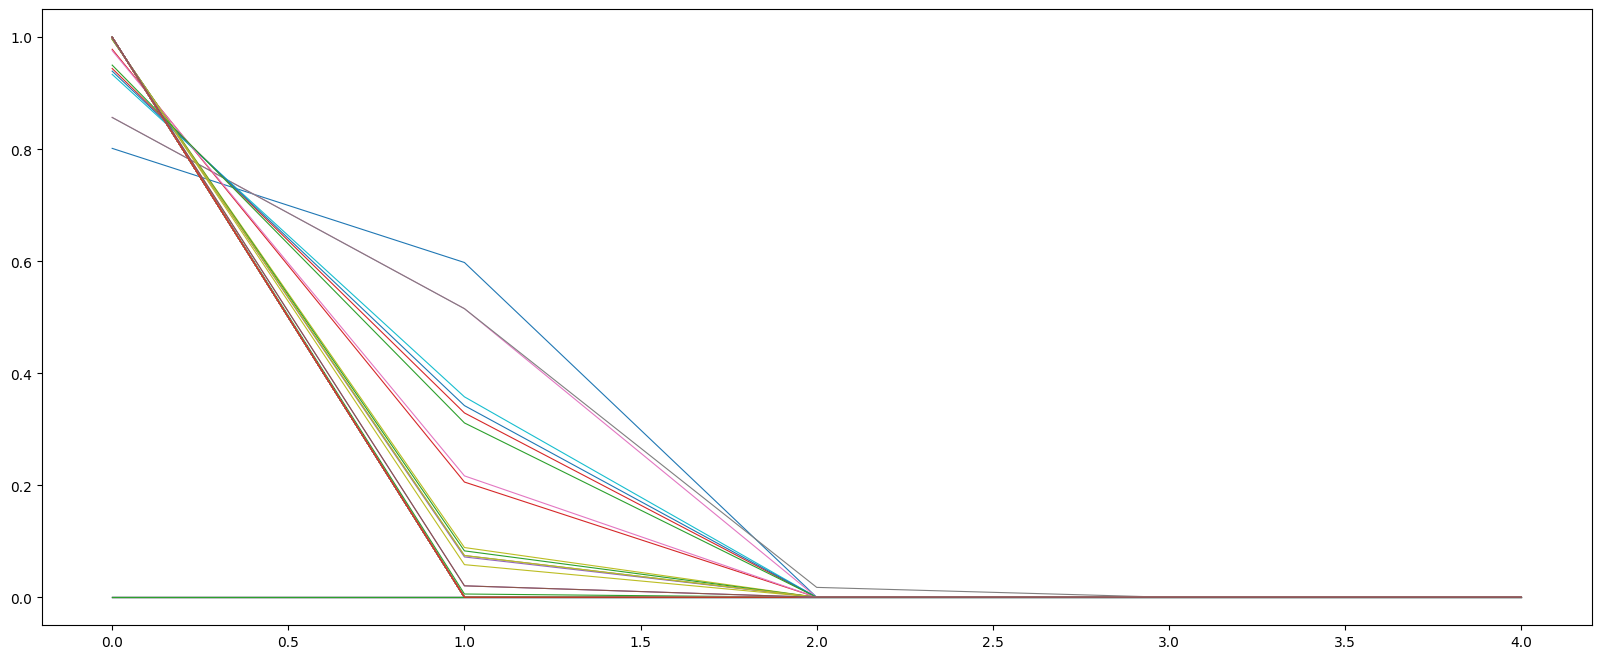

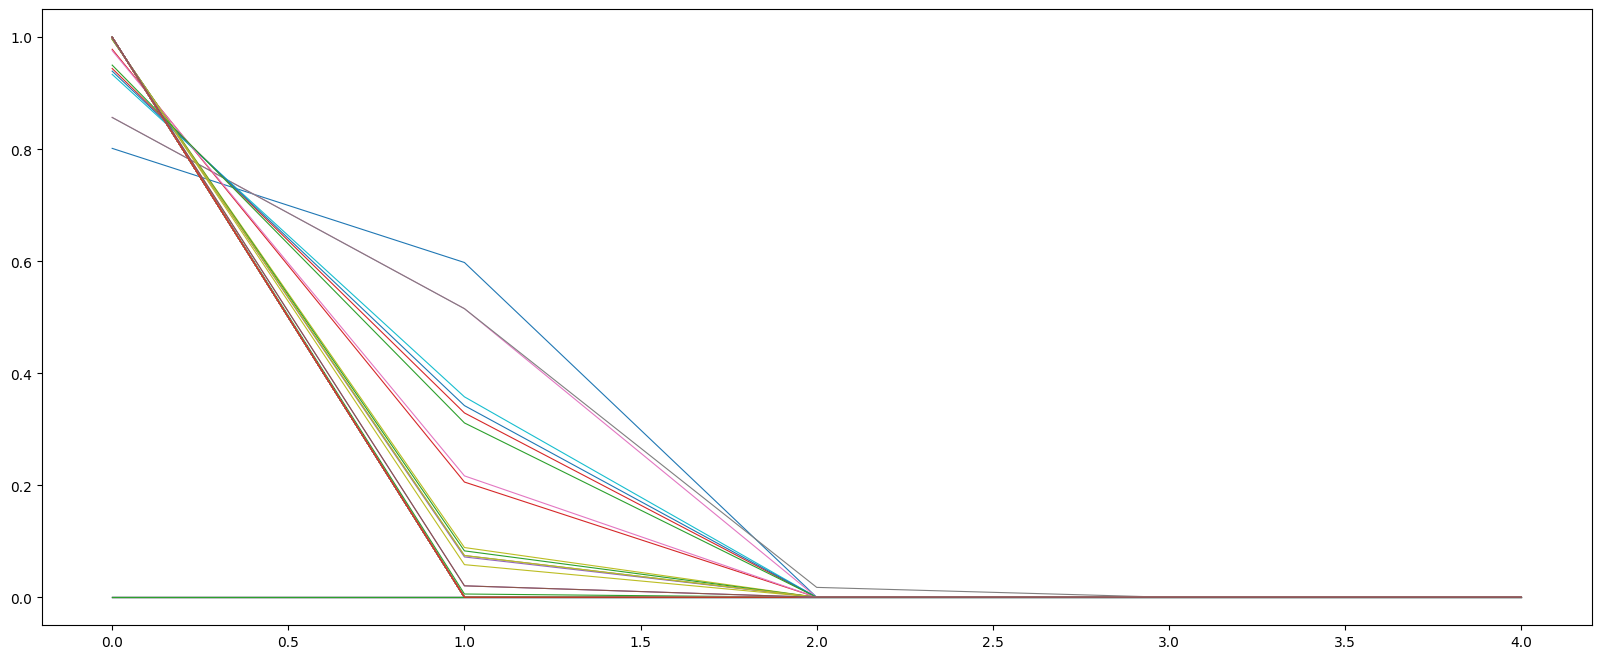

In [58]:
L1_norms.plot(figsize = (20, 8), lw = 0.8, legend = [])
L2_norms.plot(figsize = (20, 8), lw = 0.8, legend = [])

<Axes: >

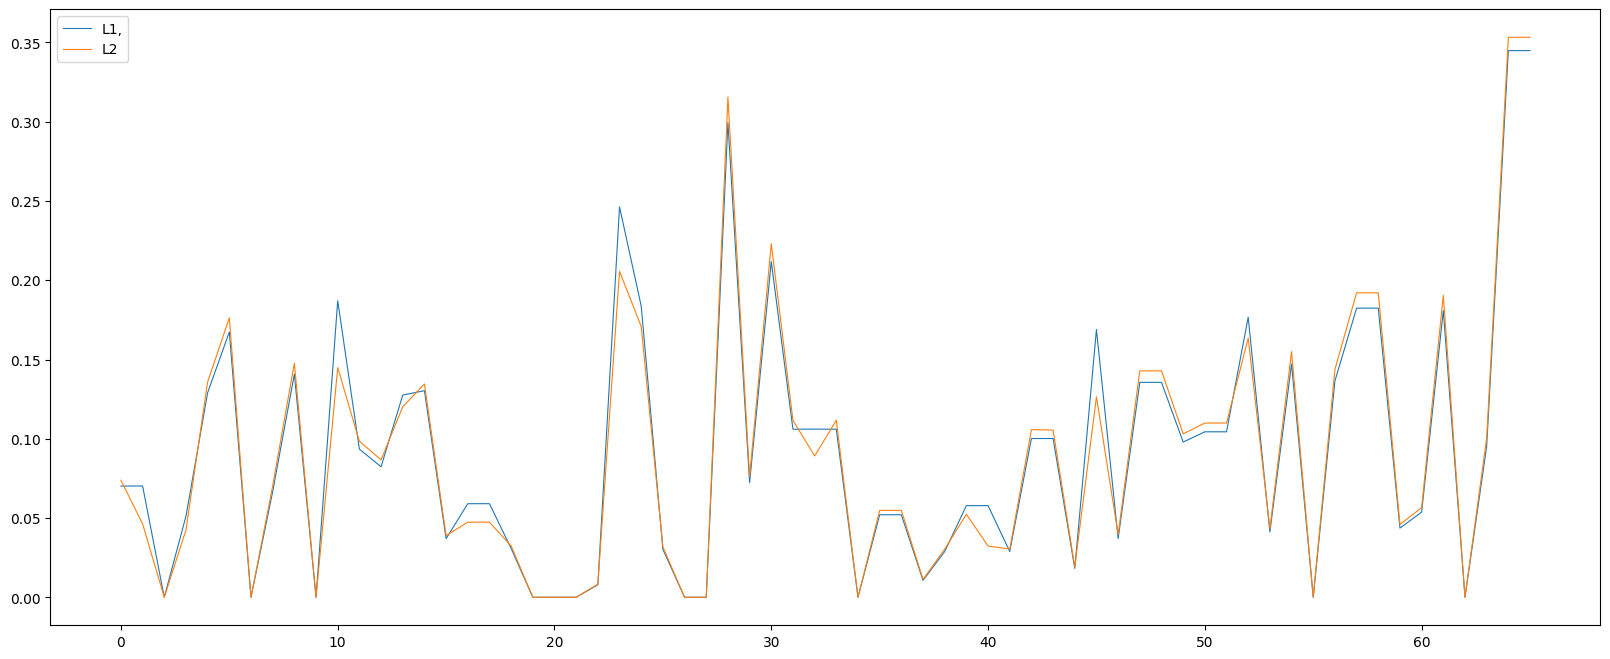

In [59]:
norms_df = getNormsOfPersistenceLandscapes(example_landscapes)
df = pd.DataFrame(norms_df, columns = ["L1,", "L2"])
df.plot(figsize = (20, 8), lw = 0.8)

In [64]:
def sleep_wake(starting_index, data_size, landscapes, window_size, n_nodes, memory_saving):
    #data setup
    data = usable_data

    #computing diagrams and landscapes
    diagrams = getAllPersistenceDiagrams(data, window_size, memory_saving)
    landscapes = getAllPersistenceLandscapes(diagrams, landscapes, n_nodes, memory_saving)

    #computing L1 and L2 norms
    n = len(landscapes)
    norms_dfs = []
    for l in landscapes:
        norms_df = getNormsOfPersistenceLandscapes(l)
        df = pd.DataFrame(norms_df, columns = ["L1", "L2"])
        norms_dfs.append(df)
    
    L1_norms = np.array([norms_df["L1"] for norms_df in norms_dfs]).T
    L1_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])
    
    L2_norms = np.array([norms_df["L2"] for norms_df in norms_dfs]).T
    L2_norms = pd.DataFrame(L1_norms, columns = [f"var_{v+1}" for v in range(n)])

    #plotting norms
    norms_df = getNormsOfPersistenceLandscapes(landscapes)
    df = pd.DataFrame(norms_df, columns = ["L1,", "L2"])
    df.plot(figsize = (20, 8), lw = 0.8)


ValueError: Shape of passed values is (0, 1), indices imply (0, 0)

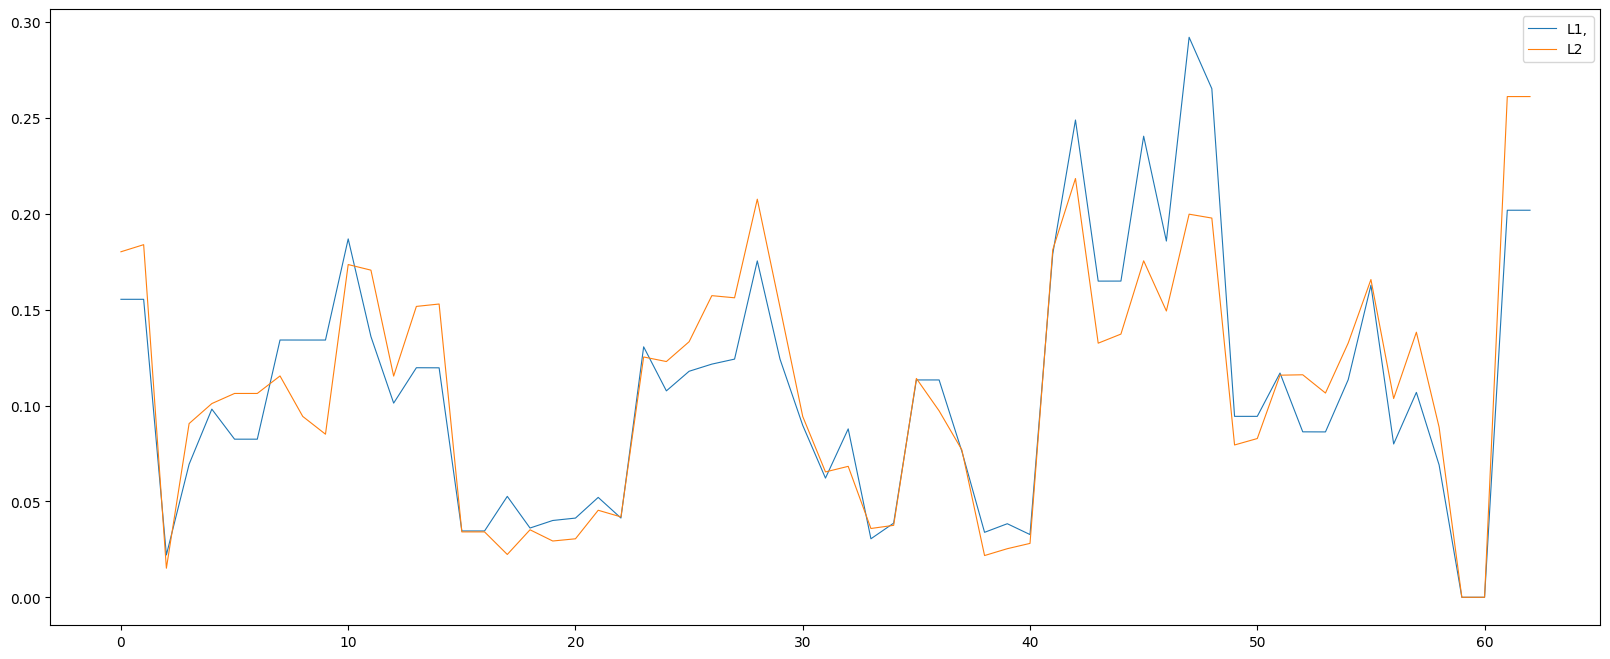

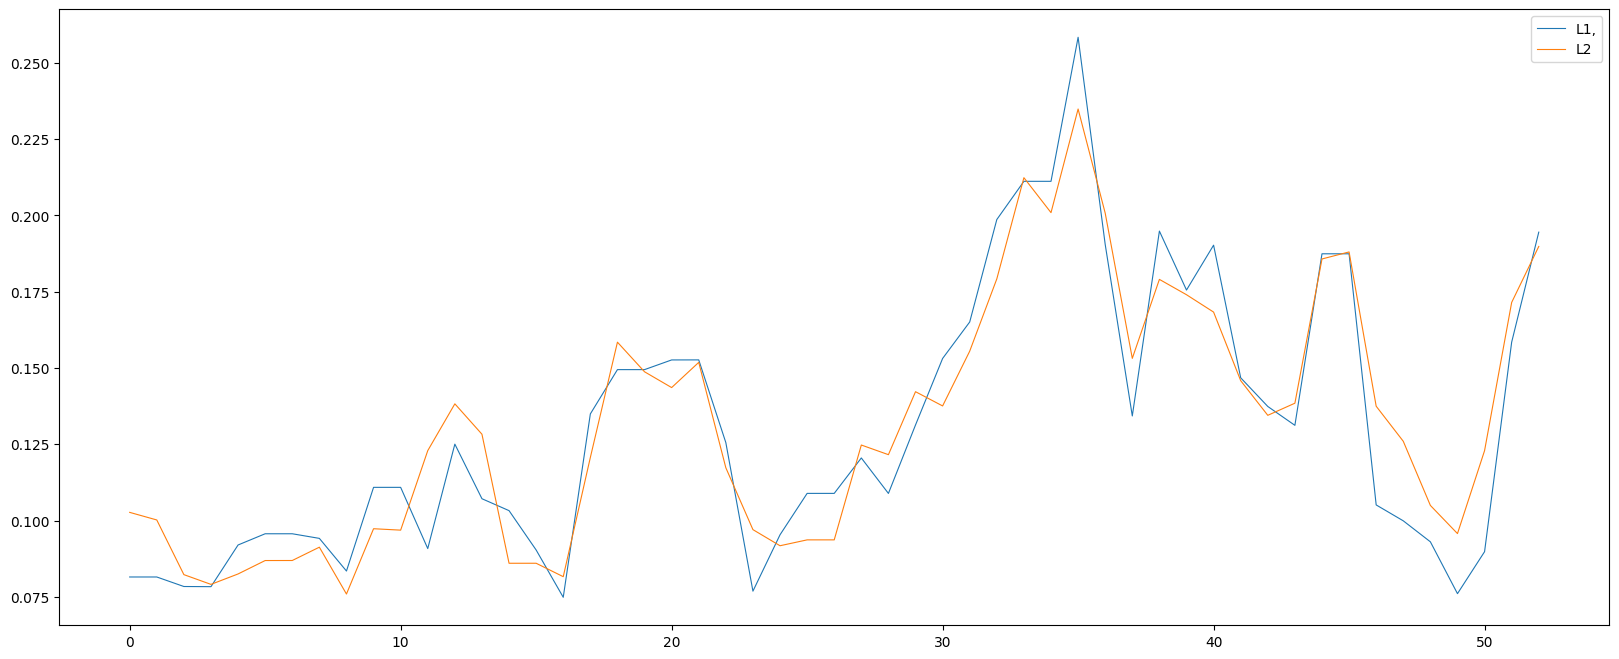

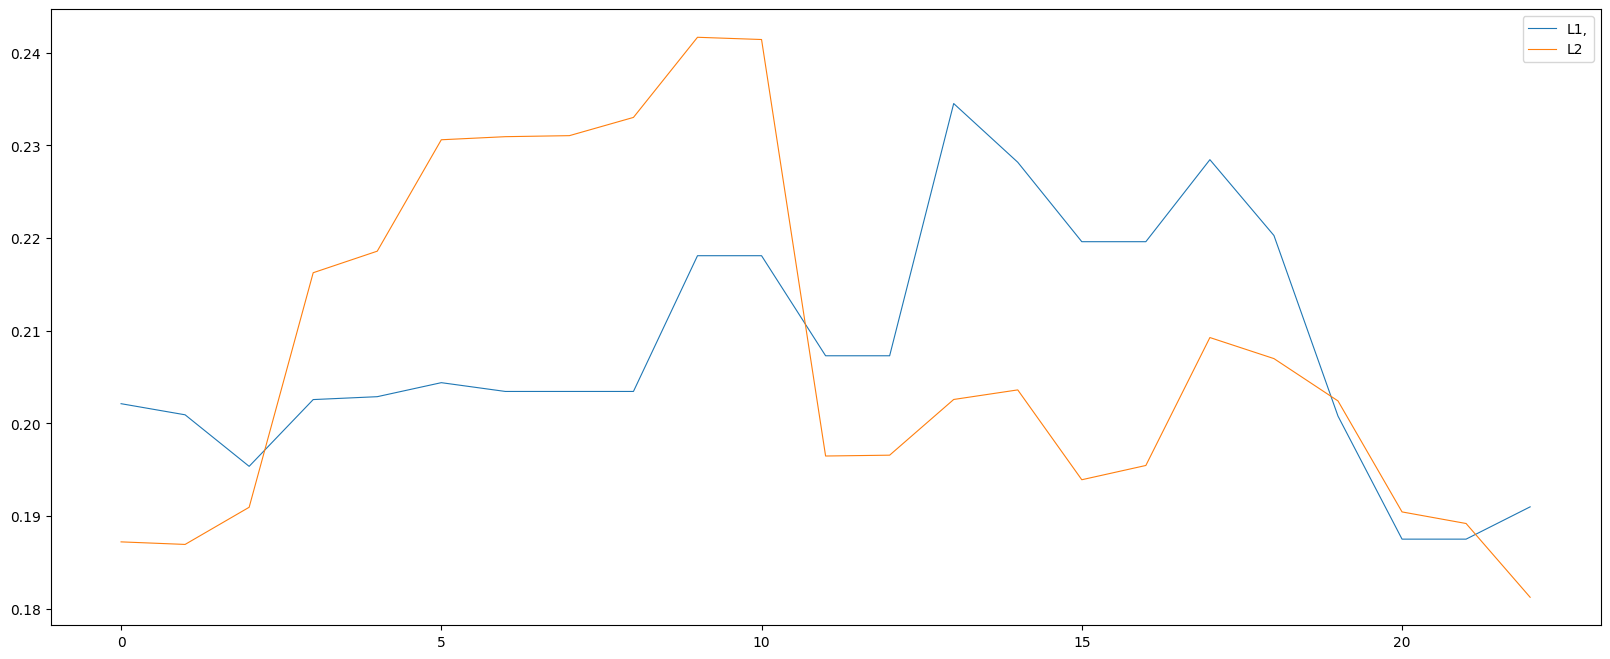

In [65]:
# Works for full dataset, no difference on RAM usage while running with larger window_sizes, but time difference is noticable
starting_index = 0
data_size = len(usable_data)
n_landscape = 5
window_sizes = [10, 20, 50, 75] # 100, 125, 150, ...
n_nodes = 1000
memory_saving = True
for window_size in window_sizes:
    sleep_wake(starting_index, data_size, n_landscape,
                                 window_size, n_nodes, memory_saving)